# Tutorial 1 : Thermomechanical Model


# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The following tutorial presents a simple usage of the geodynamics module.
The *geodynamics* module intents to facilitate rapid prototyping of geodynamics models. It can be seen as a set of high-level functions within the underworld ecosystem. It is a means to quickly get the user into Underworld modelling and assumes very little knowledge in coding. The module make some assumptions based on how the user defines the boundary conditions and the properties of the materials (rocks, phases). 

Its simplicity comes with a relatively more rigid workflow (compared to the classic Underworld functions).
However, the user can easily break the high level objects and get back to core Underworld function at any step of model design. As we think the low-level interface is more flexible, and in so allows for more complex models, we strongly encourage users to explore and break the High Level functions. We hope that the user will naturally move to the low-level functionalities as he or her gets more confident, and by doing so will access the wide range of possibilities offered by Underworld.

![Tutorial 1](./images/Tutorial1_5Myr.png)


The module can be imported as follows:

In [1]:
import UWGeodynamics as GEO

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [4]:
Model = GEO.Model(elementRes=(192, 64), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial1"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0.0 * u.kilometer))
uppercrust = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer(top=stickyAir.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=uppercrust.bottom, bottom=-100.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))

In [8]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [9]:
air.density = 1. * u.kilogram / u.metre**3
stickyAir.density = 1. * u.kilogram / u.metre**3
uppercrust.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantleLithosphere.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantle.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)

In [10]:
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [11]:
rh = GEO.ViscousCreepRegistry()

In [12]:
air.viscosity                = 1e19 * u.pascal * u.second
stickyAir.viscosity          = 1e20 * u.pascal * u.second
uppercrust.viscosity         = 30. * rh.Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = 5.0 * rh.Karato_and_Wu_1990
mantle.viscosity             = 1.0 * rh.Karato_and_Wu_1990

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [13]:
pl = GEO.PlasticityRegistry()

In [14]:
uppercrust.plasticity         = pl.Huismans_et_al_2011_Crust
mantleLithosphere.plasticity  = pl.Huismans_et_al_2011_Crust
mantle.plasticity             = pl.Huismans_et_al_2011_Crust

In [15]:
air

In [16]:
uppercrust

## Temperature Boundary Conditions

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])

## Velocity Boundary Conditions

In [18]:
Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle.index, average=True))

## Initial Damage

In [19]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))


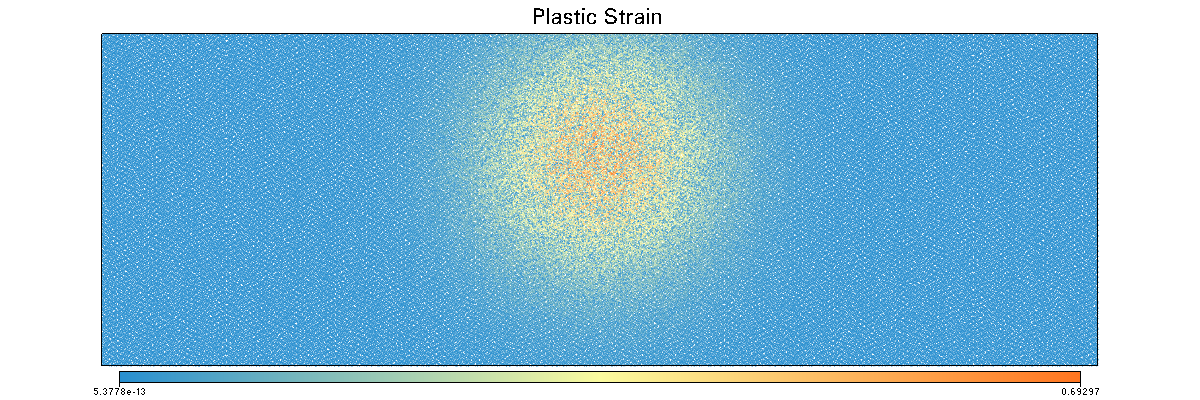

In [20]:
Fig = Model.plot.plastic_strain(figsize=(1200,400),fn_size=2)


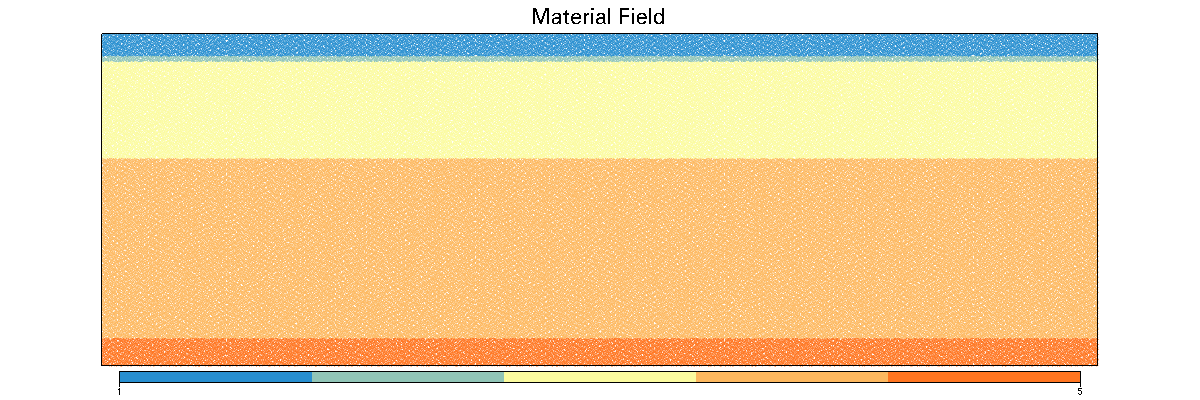

In [21]:
Fig = Model.plot.material(figsize=(1200,400), fn_size=2)

In [22]:
Model.init_model()


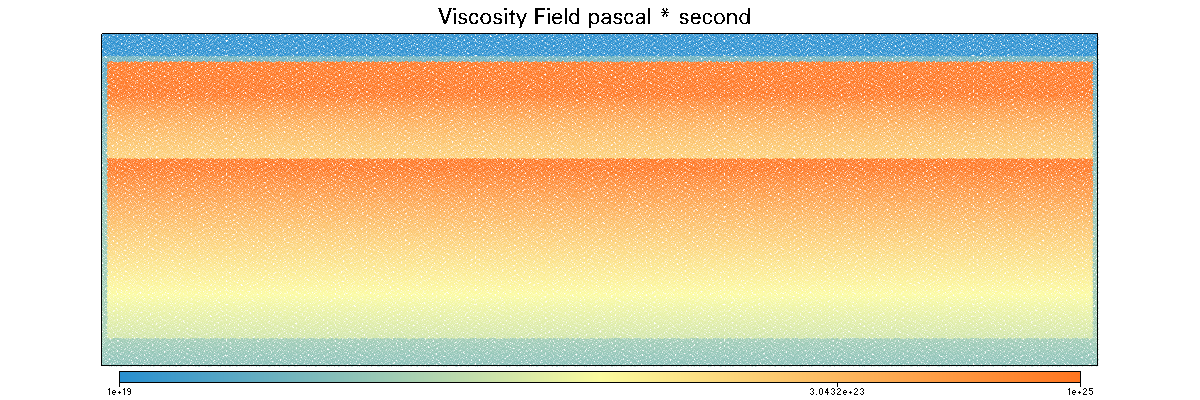

In [23]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2)

In [24]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [25]:
Model.run_for(5.0 * u.megayear, checkpoint_interval=0.1*u.megayear)

Time:  0.0076281347193 megayear dt: 0.0076281347193 megayear
Time:  0.0157663283397 megayear dt: 0.00813819362041 megayear
Time:  0.0239051696712 megayear dt: 0.00813884133151 megayear
Time:  0.0320447001814 megayear dt: 0.00813953051018 megayear
Time:  0.0401847756591 megayear dt: 0.0081400754777 megayear
Time:  0.0483247281233 megayear dt: 0.00813995246416 megayear
Time:  0.0564648712085 megayear dt: 0.00814014308525 megayear
Time:  0.0646047642612 megayear dt: 0.00813989305271 megayear
Time:  0.0727448214611 megayear dt: 0.00814005719993 megayear
Time:  0.0808851537963 megayear dt: 0.00814033233512 megayear
Time:  0.0890249916921 megayear dt: 0.00813983789588 megayear
Time:  0.0971646656981 megayear dt: 0.00813967400596 megayear
Time:  0.1 megayear dt: 0.0028353343019 megayear
Time:  0.108139622633 megayear dt: 0.00813962263312 megayear
Time:  0.116279398769 megayear dt: 0.00813977613553 megayear
Time:  0.124419078048 megayear dt: 0.00813967927918 megayear
Time:  0.132558935159 mega

1


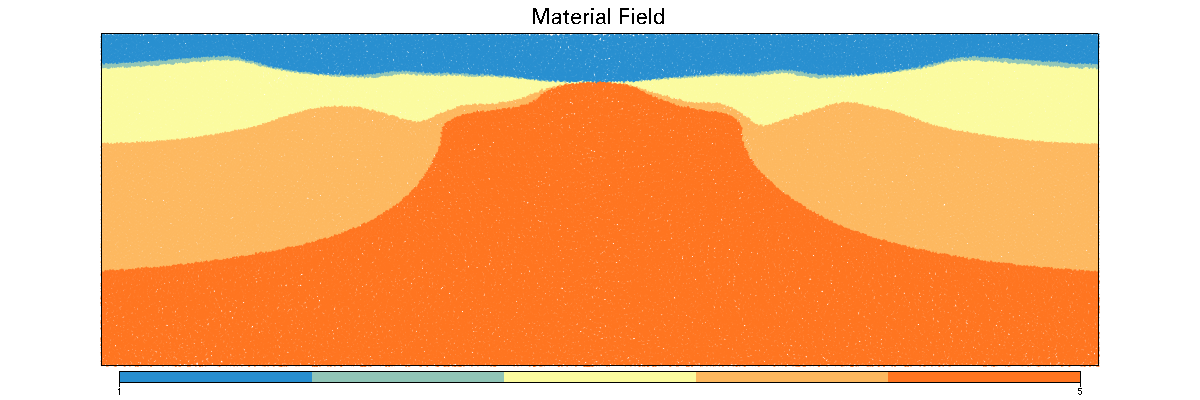

In [28]:
Fig = Model.plot.materialField(figsize=(1200,400), fn_size=3)


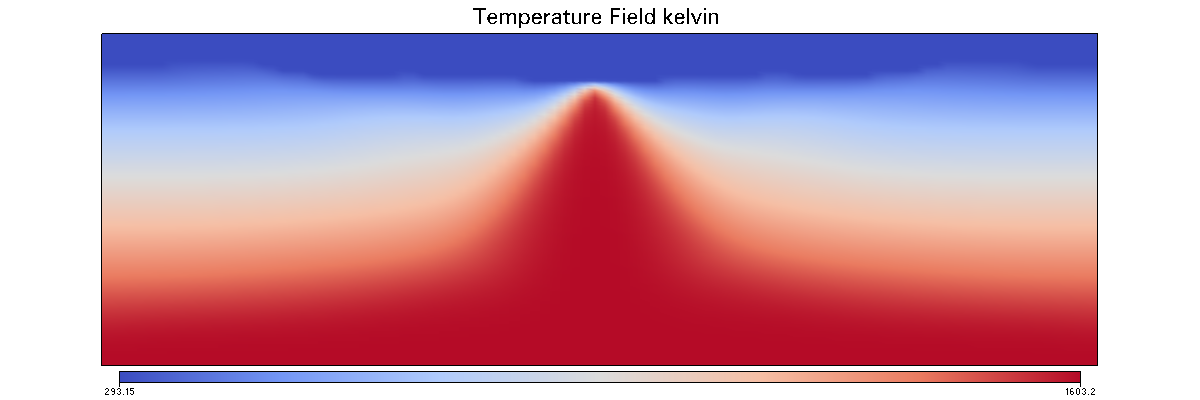

In [29]:
Fig = Model.plot.temperature(figsize=(1200,400))